# TAD Calling

In [1]:
import os, json
import importlib
import warnings
import numpy as np
import pandas as pd
from scipy import stats
from matplotlib import pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable
from utils.data import DataTree

import snapfish2 as sf
importlib.reload(sf)

<module 'snapfish2' from '/Users/redfishhh/Documents/research/MultiplexedFISH/LoopTests/snapfish2/__init__.py'>

In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
out_dire = "../123ACElog/050925"
dtree = DataTree("../data")

## Boundary overlap between original and noisy data

In [4]:
loader = sf.pp.FOF_CT_Loader({
    "rep1": dtree["takei_nature_2021", "25Kb", "rep1"],
    "rep2": dtree["takei_nature_2021", "25Kb", "rep2"]
}, voxel_ratio={"X": 103, "Y": 103, "Z": 250})
noisy_loader = sf.pp.FOF_CT_Loader({
    "rep1": os.path.join(out_dire, "takei_nature_25kb_rep1.csv"),
    "rep2": os.path.join(out_dire, "takei_nature_25kb_rep2.csv")
}, voxel_ratio={"X": 103, "Y": 103, "Z": 250})

In [5]:
count_df = []
for chr_id in loader.chr_ids:
    adata = loader.create_adata(chr_id)
    count_df.append([chr_id, adata.shape[0], np.mean(~np.isnan(adata.layers["X"]))])
count_df = pd.DataFrame(count_df, columns=["chr_id", "n_cells", "mean_count"])

In [6]:
count_df.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
chr_id,chr1,chr2,chr3,chr4,chr5,chr6,chr7,chr8,chr9,chr10,chr11,chr12,chr13,chr14,chr15,chr16,chr17,chr18,chr19,chrX
n_cells,937,937,910,924,901,921,979,968,944,936,984,942,940,927,897,931,929,948,1045,483
mean_count,0.650125,0.543436,0.702198,0.637662,0.627026,0.618874,0.617314,0.663309,0.647811,0.659633,0.641396,0.613482,0.599681,0.684484,0.617874,0.633154,0.653014,0.604342,0.533365,0.671498


In [7]:
dete_eff = (count_df.n_cells*count_df.mean_count).sum()/count_df.n_cells.sum()
print(f"Detection efficiency: {dete_eff*100:.2f} cells per cell")

Detection efficiency: 62.93 cells per cell


In [18]:
res_sf1_path = os.path.join(out_dire, "tad_result_sf1.csv")
if not os.path.exists(res_sf1_path):
    tad = sf.tl.TADCaller(tree=False, method="insulation", 
                          prominence=0.04, distance=2)
    sf.wr.caller_wrapper(loader, tad=tad, tad_path=res_sf1_path)
res_sf1 = pd.read_csv(res_sf1_path, sep="\t")
res_sf2_path = os.path.join(out_dire, "tad_result_sf2.csv")
if not os.path.exists(res_sf2_path):
    tad = sf.tl.TADCaller(tree=False, method="pval")
    sf.wr.caller_wrapper(loader, tad=tad, tad_path=res_sf2_path)
res_sf2 = pd.read_csv(res_sf2_path, sep="\t")

In [19]:
res_sf1_noisy_path = os.path.join(out_dire, "tad_result_sf1_noisy.csv")
if not os.path.exists(res_sf1_noisy_path):
    tad = sf.tl.TADCaller(tree=False, method="insulation", 
                          prominence=0.04, distance=2)
    sf.wr.caller_wrapper(noisy_loader, tad=tad, tad_path=res_sf1_noisy_path)
res_sf1_noisy = pd.read_csv(res_sf1_noisy_path, sep="\t")
res_sf2_noisy_path = os.path.join(out_dire, "tad_result_sf2_noisy.csv")
if not os.path.exists(res_sf2_noisy_path):
    tad = sf.tl.TADCaller(tree=False, method="pval")
    sf.wr.caller_wrapper(noisy_loader, tad=tad, tad_path=res_sf2_noisy_path)
res_sf2_noisy = pd.read_csv(res_sf2_noisy_path, sep="\t")

In [7]:
from utils.utils import domain_output_to_boundary
domain_output_to_boundary(res_sf1_noisy)
overlap1 = sf.tl.signal_overlap(
    domain_output_to_boundary(res_sf1_noisy),
    domain_output_to_boundary(res_sf1),
)
a = 1 - overlap1.overlapped
print(f"Noisy specific: {np.sum(a)} ({(np.mean(a)*100).round(1)}%)")

Noisy specific: 22 (33.8%)


In [8]:
overlap2 = sf.tl.signal_overlap(
    domain_output_to_boundary(res_sf2_noisy),
    domain_output_to_boundary(res_sf2),
)
a = 1 - overlap2.overlapped
print(f"Noisy specific: {np.sum(a)} ({(np.mean(a)*100).round(1)}%)")

Noisy specific: 4 (4.1%)


In [9]:
shared1 = np.sum(overlap1.overlapped)
raw_df1 = domain_output_to_boundary(res_sf1)
shared2 = np.sum(overlap2.overlapped)
raw_df2 = domain_output_to_boundary(res_sf2)
df = pd.DataFrame({
    "Insulation": [shared1, len(overlap1) - shared1, len(raw_df1) - shared1],
    "SnapFISH2": [shared2, len(overlap2) - shared2, len(raw_df2) - shared2]
}).T
df.columns = ["Shared", "Raw Specific", "Noisy Specific"]
# shared_color = sns.color_palette("dark")[-2]
# raw_spe_color = sns.color_palette("dark")[0]
# noi_spe_color = sns.color_palette("dark")[3]

shared_color = plt.colormaps["RdBu"](100)
raw_spe_color = plt.colormaps["RdBu"](10)
noi_spe_color = plt.colormaps["RdBu"](240)

color=[shared_color, raw_spe_color, noi_spe_color]
df_norm = df.div(df.sum(axis=1), axis=0)

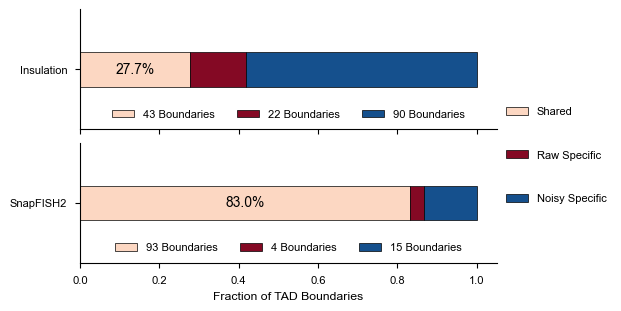

In [10]:
fig = plt.figure(figsize=(6, 3))
figs = fig.subfigures(1, 2, width_ratios=[1, .2])
axes = figs[0].subplots(2, 1, sharex=True)
df_norm.iloc[:1].plot(kind="barh", stacked=True, linewidth=.5, edgecolor="k",
                      color=color, width=0.2, ax=axes[0])
axes[0].grid(False)
lbls = [f"{n} Boundaries" for n in df.loc["Insulation"].values]
axes[0].legend(labels=lbls, loc="lower center", ncol=3)
bar = axes[0].patches[0]
axes[0].text(bar.get_x()+bar.get_width()/2, bar.get_y()+bar.get_height()/2,
             f"{bar.get_width()*100:.1f}%", ha="center", verticalalignment="center")

df_norm.iloc[1:].plot(kind="barh", stacked=True, linewidth=.5, edgecolor="k",
                      color=color, width=0.2, ax=axes[1])
axes[1].grid(False)
lbls = [f"{n} Boundaries" for n in df.loc["SnapFISH2"].values]
axes[1].legend(labels=lbls, loc="lower center", ncol=3)
bar = axes[1].patches[0]
axes[1].text(bar.get_x()+bar.get_width()/2, bar.get_y()+bar.get_height()/2,
             f"{bar.get_width()*100:.1f}%", ha="center", verticalalignment="center")
axes[1].set_xlabel("Fraction of TAD Boundaries")

handles, labels = axes[1].get_legend_handles_labels()
figs[1].legend(handles, labels, loc="center", ncol=1, labelspacing=3)
fig.savefig(os.path.join(out_dire, "tad_overlap.pdf"), bbox_inches="tight")

## Example TAD calling

In [11]:
chr_id = "chr3"
adata = loader.create_adata(chr_id)
adata_noisy = noisy_loader.create_adata(chr_id)

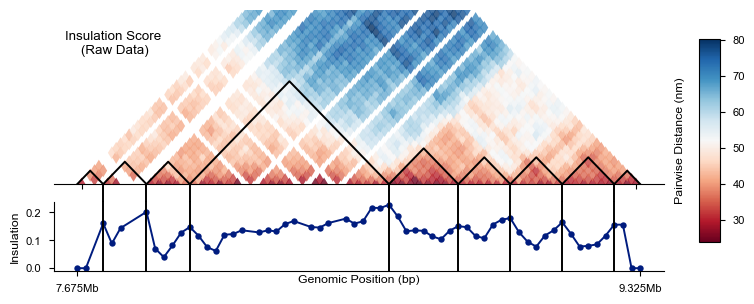

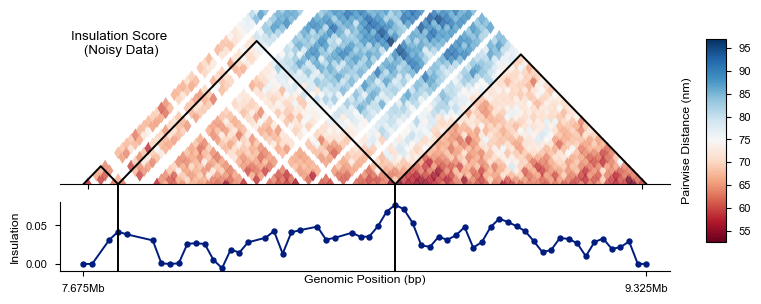

/opt/miniconda3/lib/python3.12/site-packages/dask/_task_spec.py:744: RuntimeWarning: All-NaN slice encountered
  return self.func(*new_argspec, **kwargs)
/opt/miniconda3/lib/python3.12/site-packages/dask/_task_spec.py:744: RuntimeWarning: All-NaN slice encountered
  return self.func(*new_argspec, **kwargs)
/opt/miniconda3/lib/python3.12/site-packages/dask/_task_spec.py:744: RuntimeWarning: All-NaN slice encountered
  return self.func(*new_argspec, **kwargs)
/opt/miniconda3/lib/python3.12/site-packages/dask/_task_spec.py:744: RuntimeWarning: All-NaN slice encountered
  return self.func(*new_argspec, **kwargs)
/opt/miniconda3/lib/python3.12/site-packages/dask/_task_spec.py:744: RuntimeWarning: All-NaN slice encountered
  return self.func(*new_argspec, **kwargs)


In [12]:
caller1 = sf.tl.TADCaller(tree=False, method="insulation", 
                         prominence=0.04, distance=2)
fig = plt.figure(figsize=(7, 2.7))
ax, cbar, cax = sf.pl.triangle_domain_boundary(adata, caller1, fig=fig)
cbar.set_label("Pairwise Distance (nm)", labelpad=-50)
ax.set_title(f"Insulation Score \n(Raw Data)", y=0.7, x=0.1)
fig.savefig(os.path.join(out_dire, "triangle_tad_insulation_raw.pdf"), bbox_inches="tight")

fig = plt.figure(figsize=(7, 2.7))
ax, cbar, cax = sf.pl.triangle_domain_boundary(adata_noisy, caller1, fig=fig)
cbar.set_label("Pairwise Distance (nm)", labelpad=-50)
ax.set_title(f"Insulation Score \n(Noisy Data)", y=0.7, x=0.1)
fig.savefig(os.path.join(out_dire, "triangle_tad_insulation_noi.pdf"), bbox_inches="tight")

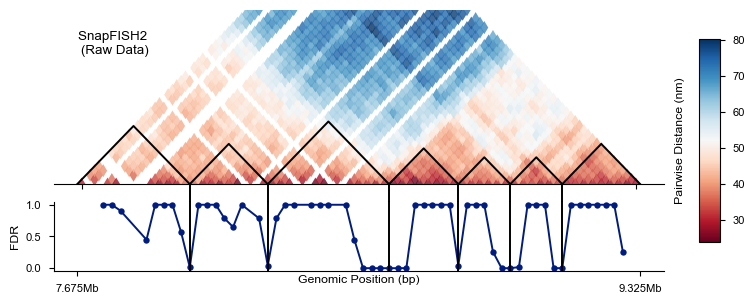

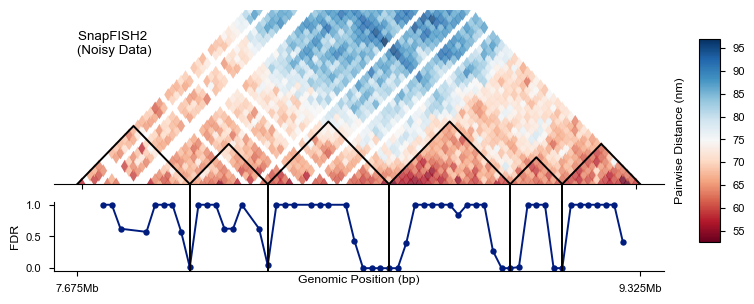

/opt/miniconda3/lib/python3.12/site-packages/dask/_task_spec.py:744: RuntimeWarning: All-NaN slice encountered
  return self.func(*new_argspec, **kwargs)
/opt/miniconda3/lib/python3.12/site-packages/dask/_task_spec.py:744: RuntimeWarning: All-NaN slice encountered
  return self.func(*new_argspec, **kwargs)
/opt/miniconda3/lib/python3.12/site-packages/dask/_task_spec.py:744: RuntimeWarning: All-NaN slice encountered
  return self.func(*new_argspec, **kwargs)
/opt/miniconda3/lib/python3.12/site-packages/dask/_task_spec.py:744: RuntimeWarning: All-NaN slice encountered
  return self.func(*new_argspec, **kwargs)
/opt/miniconda3/lib/python3.12/site-packages/dask/_task_spec.py:744: RuntimeWarning: All-NaN slice encountered
  return self.func(*new_argspec, **kwargs)
/opt/miniconda3/lib/python3.12/site-packages/dask/_task_spec.py:744: RuntimeWarning: All-NaN slice encountered
  return self.func(*new_argspec, **kwargs)
/opt/miniconda3/lib/python3.12/site-packages/dask/_task_spec.py:744: Runtime

In [13]:
caller2 = sf.tl.TADCaller(tree=False, method="pval", fdr_cutoff=.1)
fig = plt.figure(figsize=(7, 2.7))
ax, cbar, cax = sf.pl.triangle_domain_boundary(adata, caller2, fig=fig)
cbar.set_label("Pairwise Distance (nm)", labelpad=-50)
ax.set_title(f"SnapFISH2 \n(Raw Data)", y=0.7, x=0.1)
fig.savefig(os.path.join(out_dire, "triangle_tad_pval_raw.pdf"), bbox_inches="tight")

fig = plt.figure(figsize=(7, 2.7))
ax, cbar, cax = sf.pl.triangle_domain_boundary(adata_noisy, caller2, fig=fig)
cbar.set_label("Pairwise Distance (nm)", labelpad=-50)
ax.set_title(f"SnapFISH2 \n(Noisy Data)", y=0.7, x=0.1)
fig.savefig(os.path.join(out_dire, "triangle_tad_pval_noi.pdf"), bbox_inches="tight")

In [14]:
insu_path = os.path.join(out_dire, "tad_insulation.csv")
pval_path = os.path.join(out_dire, "tad_pval.csv")
dfs = {"Insulation": [], "SnapFISH2": []}
if not os.path.exists(insu_path):
    for c in loader.chr_ids:
        adata = loader.create_adata(c)
        adata_noisy = noisy_loader.create_adata(c)
        
        df1 = caller1.call_tads(adata)
        df1 = df1[df1["insulation"] > 0]
        df2 = caller1.call_tads(adata_noisy)
        df2 = df2[df2["insulation"] > 0]
        dfs["Insulation"].append(pd.merge(
            df1, df2, on=["c1", "Chrom_Start", "Chrom_End"],
        ))
        
        df1 = caller2.call_tads(adata).dropna()
        df2 = caller2.call_tads(adata_noisy).dropna()
        dfs["SnapFISH2"].append(pd.merge(
            df1, df2, on=["c1", "Chrom_Start", "Chrom_End"],
        ))
    dfs["Insulation"] = pd.concat(dfs["Insulation"])
    dfs["SnapFISH2"] = pd.concat(dfs["SnapFISH2"])
    dfs["Insulation"].to_csv(insu_path, index=False)
    dfs["SnapFISH2"].to_csv(pval_path, index=False)
else:
    dfs["Insulation"] = pd.read_csv(insu_path)
    dfs["SnapFISH2"] = pd.read_csv(pval_path)

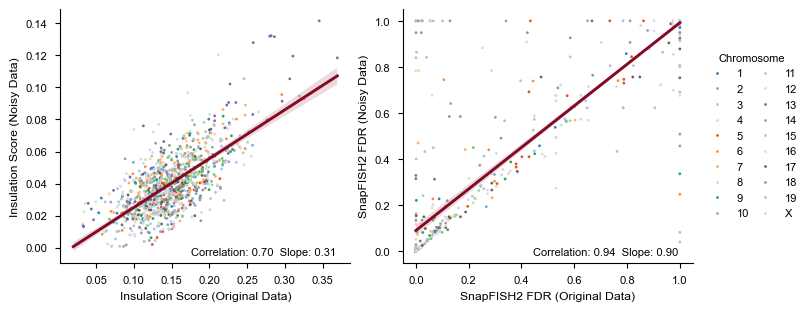

In [15]:
fig, axes = plt.subplots(1, 3, figsize=(8, 3), width_ratios=[1, 1, 0.2])

insu = dfs["Insulation"].copy()
sns.scatterplot(insu, x="insulation_x", y="insulation_y", hue="c1",
                s=4, linewidth=0, palette="tab20c", ax=axes[0])
sns.regplot(insu, x="insulation_x", y="insulation_y",
            scatter=False, color=raw_spe_color, ax=axes[0])
axes[0].grid(False)
handles, labels = axes[0].get_legend_handles_labels()
axes[0].get_legend().remove()
r, p = stats.pearsonr(insu["insulation_x"], insu["insulation_y"])
s = stats.linregress(insu["insulation_x"], insu["insulation_y"]).slope
axes[0].text(
    0.95, 0.02,
    f"Correlation: {r:.2f}  Slope: {s:.2f}",
    transform=axes[0].transAxes,
    fontsize=8,
    verticalalignment="bottom",
    horizontalalignment="right"
)
axes[0].set(xlabel="Insulation Score (Original Data)",
            ylabel="Insulation Score (Noisy Data)")

fdr = dfs["SnapFISH2"].reset_index(drop=True)
sns.scatterplot(fdr, x="fdr_x", y="fdr_y", hue="c1",
                s=4, linewidth=0, palette="tab20c", ax=axes[1])
sns.regplot(fdr, x="fdr_x", y="fdr_y", robust=False,
            scatter=False, color=raw_spe_color, ax=axes[1])
axes[1].grid(False)
handles, labels = axes[1].get_legend_handles_labels()
axes[1].get_legend().remove()
r, p = stats.pearsonr(fdr["fdr_x"], fdr["fdr_y"])
s = stats.linregress(fdr["fdr_x"], fdr["fdr_y"]).slope
axes[1].text(
    0.95, 0.02,
    f"Correlation: {r:.2f}  Slope: {s:.2f}",
    transform=axes[1].transAxes,
    fontsize=8,
    verticalalignment="bottom",
    horizontalalignment="right"
)
axes[1].set(xlabel="SnapFISH2 FDR (Original Data)",
            ylabel="SnapFISH2 FDR (Noisy Data)")

labels = [l[3:] for l in labels]
axes[2].legend(handles, labels, title="Chromosome", title_fontsize=8,
               ncol=2, loc="center", columnspacing=.4)
axes[2].axis("off")

fig.savefig(os.path.join(out_dire, "tad_correlation.pdf"), bbox_inches="tight")

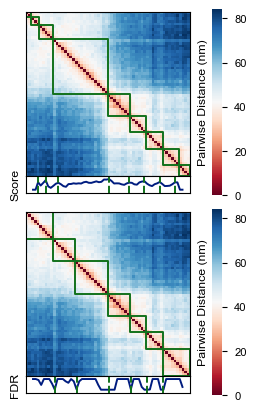

In [5]:
chr_id = "chr3"
adata = loader.create_adata(chr_id)

fig, axes = plt.subplots(2, 1, figsize=(2.3, 4))
caller = sf.tl.TADCaller(tree=False, method="insulation", 
                         prominence=0.04, distance=2)
sf.pl.domain_boundary(adata, caller, ax=axes[0])
caller = sf.tl.TADCaller(tree=False, method="pval")
sf.pl.domain_boundary(adata, caller, ax=axes[1])
for ax in axes:
    cbar = ax.collections[0].colorbar
    cbar.set_label("Pairwise Distance (nm)", labelpad=-35)    
fig.savefig(os.path.join(out_dire, f"{chr_id}_TAD.pdf"), bbox_inches="tight")

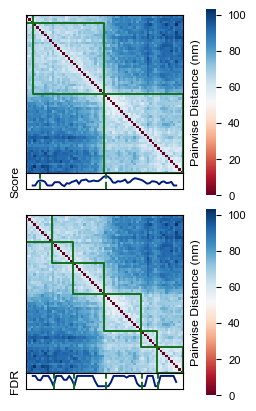

In [6]:
chr_id = "chr3"
adata = noisy_loader.create_adata(chr_id)

fig, axes = plt.subplots(2, 1, figsize=(2.3, 4))
caller = sf.tl.TADCaller(tree=False, method="insulation", 
                         prominence=0.04, distance=2)
sf.pl.domain_boundary(adata, caller, ax=axes[0])
caller = sf.tl.TADCaller(tree=False, method="pval")
sf.pl.domain_boundary(adata, caller, ax=axes[1])
for ax in axes:
    cbar = ax.collections[0].colorbar
    cbar.set_label("Pairwise Distance (nm)", labelpad=-40)
fig.savefig(os.path.join(out_dire, f"{chr_id}_TAD_noisy.pdf"), bbox_inches="tight")

## Correlation with ChIP-seq

In [17]:
from utils.maps import cpmt_enrichment
res1 = dfs["Insulation"].rename({
    "Chrom_Start": "s1", "Chrom_End": "e1",
    "peak_x": "cpmt"
}, axis=1)[["c1", "s1", "e1", "cpmt"]]
res2 = dfs["Insulation"].rename({
    "Chrom_Start": "s1", "Chrom_End": "e1",
    "peak_y": "cpmt"
}, axis=1)[["c1", "s1", "e1", "cpmt"]]

In [18]:
from utils.utils import domain_chipseq_df
markers = dtree["chipseq_mesc"].keys()
raw_enrich_path = os.path.join(out_dire, "tad_raw_enrich_chipseq.csv")
if not os.path.exists(raw_enrich_path):
    raw_enrich_df = domain_chipseq_df(dtree, loader, res_sf1, res_sf2, markers)
    raw_enrich_df.to_csv(raw_enrich_path, index=False, sep="\t")
raw_enrich_df = pd.read_csv(raw_enrich_path, sep="\t")
noi_enrich_path = os.path.join(out_dire, "tad_noi_enrich_chipseq.csv")
if not os.path.exists(noi_enrich_path):
    noi_enrich_df = domain_chipseq_df(dtree, noisy_loader, res_sf1_noisy, res_sf2_noisy, markers)
    noi_enrich_df.to_csv(noi_enrich_path, index=False, sep="\t")
noi_enrich_df = pd.read_csv(noi_enrich_path, sep="\t")

In [19]:
markers

dict_keys(['H3K4me3', 'H3K4me1', 'H3K27ac', 'H3K36me3', 'H3K9me3', 'H3K9ac', 'CTCF', 'POLR2A'])

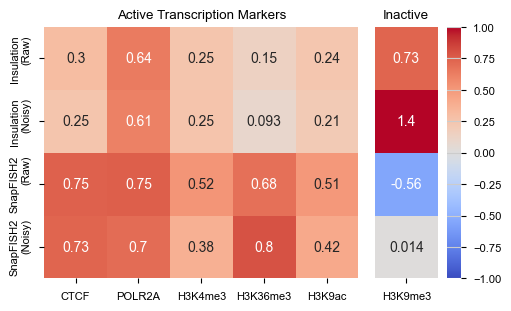

In [108]:
dfr = pd.merge(raw_enrich_df[raw_enrich_df["Method"]!="Average"], 
               raw_enrich_df[raw_enrich_df["Method"]=="Average"], on="marker")
dfr["fold"] = np.log2(dfr["frac_x"]/dfr["frac_y"])
dfr["type"] = "Raw"

dfn = pd.merge(noi_enrich_df[noi_enrich_df["Method"]!="Average"], 
               noi_enrich_df[noi_enrich_df["Method"]=="Average"], on="marker")
dfn["fold"] = np.log2(dfn["frac_x"]/dfn["frac_y"])
dfn["type"] = "Noisy"
df = pd.concat([dfr, dfn])[["marker", "fold", "type", "Method_x"]]
df.rename(columns={"Method_x": "Method"}, inplace=True)
df["Method"] = df["Method"].map({"SnapFISH": "Insulation", "SnapFISH2": "SnapFISH2"})
df["row"] = df["Method"] + "\n(" + df["type"] + ")"
plt_df = df.pivot(index="row", columns="marker", values="fold").T
plt_df = plt_df[["Insulation\n(Raw)", "Insulation\n(Noisy)", \
    "SnapFISH2\n(Raw)", "SnapFISH2\n(Noisy)"]]

up_rglt = ["CTCF", "POLR2A", "H3K4me3", "H3K36me3", "H3K9ac"]
down_rglt = ["H3K9me3"]
             
fig, axes = plt.subplots(1, 3, figsize=(len(up_rglt+down_rglt)*3/3.6,3), 
                             width_ratios=[len(up_rglt),len(down_rglt),.2])
sns.heatmap(plt_df.T[up_rglt], vmin=-1, vmax=1, annot=True, square=True,
            cmap="coolwarm", cbar=False, ax=axes[0])
labels = axes[0].get_xticklabels()
axes[0].set_xticklabels(labels, ha="center")
axes[0].set(title="Active Transcription Markers", xlabel="", ylabel="")
axes[0].grid(False)
sns.heatmap(plt_df.T[down_rglt], vmin=-1, vmax=1, annot=True, square=True,
            cmap="coolwarm", yticklabels=False, ax=axes[1], cbar_ax=axes[2])
axes[1].set(title="Inactive", xlabel="", ylabel="")
axes[1].grid(False)
fig.savefig(os.path.join(out_dire, "tad_chipseq_enrich.pdf"), bbox_inches="tight")

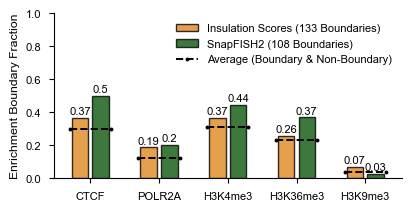

In [378]:
from utils.lines import domain_chipseq_barplot
fig, ax = plt.subplots(figsize=(4, 2))
domain_chipseq_barplot(raw_enrich_df, ax=ax)
fig.savefig(os.path.join(out_dire, "tad_raw_enrich_chipseq.pdf"), bbox_inches="tight")

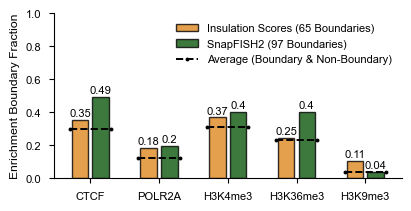

In [11]:
fig, ax = plt.subplots(figsize=(4, 2))
domain_chipseq_barplot(noi_enrich_df, ax=ax)
fig.savefig(os.path.join(out_dire, "tad_noi_enrich_chipseq.pdf"), bbox_inches="tight")

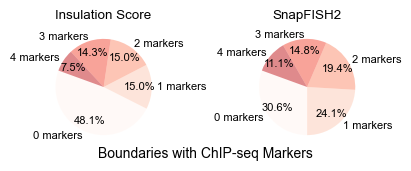

In [12]:
from utils.utils import domain_add_chipseq_col

colors = [plt.get_cmap("Reds")(i*50) for i in range(5)]
fig, axes = plt.subplots(1, 2, figsize=(4, 2))

res = res_sf1.copy()
for marker in ["CTCF", "POLR2A", "H3K4me3", "H3K36me3"]:
    res = domain_add_chipseq_col(res, marker, dtree)
labels, count = np.unique(res.iloc[:, 3:].sum(axis=1), return_counts=True)
axes[0].pie(
    count, labels=[f"{t} markers" for t in labels], textprops={"fontsize":8},
    autopct="%1.1f%%", startangle=160, labeldistance=1.1, pctdistance=.75,
    wedgeprops={"alpha": .5}, colors=colors,
)
axes[0].set_title("Insulation Score")

res = res_sf2.copy()
for marker in ["CTCF", "POLR2A", "H3K4me3", "H3K36me3"]:
    res = domain_add_chipseq_col(res, marker, dtree)
labels, count = np.unique(res.iloc[:, 3:].sum(axis=1), return_counts=True)
axes[1].pie(
    count, labels=[f"{t} markers" for t in labels], textprops={"fontsize":8},
    autopct="%1.1f%%", startangle=160, labeldistance=1.1, pctdistance=.75, 
    wedgeprops={"alpha": .5}, colors=colors
)
axes[1].set_title("SnapFISH2")

fig.suptitle("Boundaries with ChIP-seq Markers", y=0.2, fontsize=10)
fig.savefig(os.path.join(out_dire, "tad_marker_pie.pdf"), bbox_inches="tight")

## Overlap with Hi-C

In [90]:
import pyBigWig

df = loader.read_data()["rep1"].groupby("Chrom", sort=False)
chr_range = pd.merge(
    df["Chrom_Start"].min().reset_index(),
    df["Chrom_End"].max().reset_index(),
    on="Chrom"
).set_index("Chrom")

hic_insu = []
with pyBigWig.open(dtree["bonev_cell_2017","G0G1_mESC_GFP+","insulation"]) as bw:
    for chr_id, row in chr_range.iterrows():
        val = bw.values(chr_id, row["Chrom_Start"], row["Chrom_End"])
        x = np.linspace(row["Chrom_Start"], row["Chrom_End"], len(val))
        # bw is for each bp. Convert to 5kb resolution
        df = pd.DataFrame({"s1": x, "insulation": val}).iloc[::5000]
        df["c1"] = chr_id
        df["e1"] = df["s1"] + 5000
        df = df.astype({"s1": "int64", "e1": "int64"})
        hic_insu.append(df[["c1", "s1", "e1", "insulation"]])
hic_insu = pd.concat(hic_insu, ignore_index=True)

boundaries = pd.read_csv(
    dtree["bonev_cell_2017","G0G1_mESC_GFP+","boundaries"], 
    sep="\t", header=None, names=["c1", "s1", "e1", "strength", "val"],
)
hic_insu = pd.merge(hic_insu, boundaries, on=["c1", "s1", "e1"], how="left")
hic_insu["peak"] = ~hic_insu["strength"].isna()

In [115]:
caller2.method

'pval'

(191700183.91357896, 193955854.54556406)

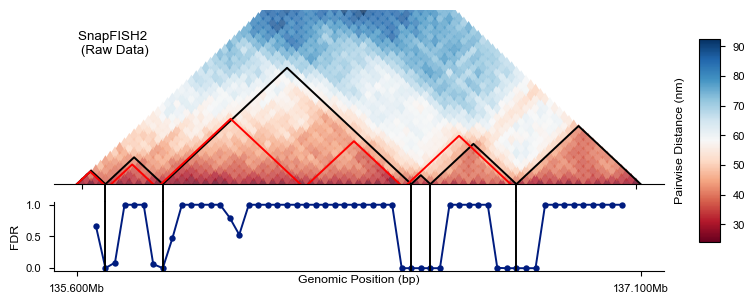

In [229]:
adata = loader.create_adata("chr1")
fig = plt.figure(figsize=(7, 2.7))
ax, cbar, cax = sf.pl.triangle_domain_boundary(adata, caller2, fig=fig)
cbar.set_label("Pairwise Distance (nm)", labelpad=-50)
ax.set_title(f"SnapFISH2 \n(Raw Data)", y=0.7, x=0.1)

caller = sf.tl.TADCaller(tree=False, method="insulation", 
                         prominence=0.04, distance=2)
df = hic_insu.rename({"s1": "Chrom_Start", "e1": "Chrom_End"}, axis=1)
for _, row in caller.to_bedpe(df).iterrows():
    # Move .5 bin up
    s = (row.s1 + row.e1)/2 - (row.e1 - row.s1)/2
    e = (row.s2 + row.e2)/2 + (row.e2 - row.s2)/2
    df = sf.pl.rotate_df(pd.DataFrame({"x": [e,s,s], "y": [e,e,s]}))
    ax.plot(df.x_rot, df.y_rot, color="red")
ax.set_xlim(*cax.get_xlim())

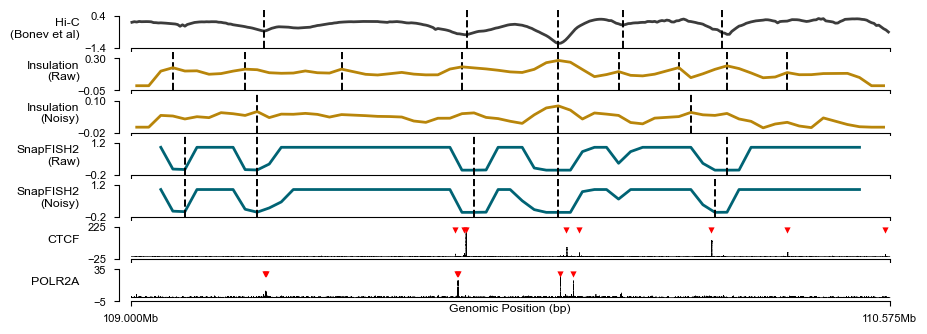

In [ ]:
chr_id = "chr2"
plt.rcParams["axes.grid"] = False
# plt.rcParams["axes.spines.bottom"] = False
axes = []
c1, c2, c3 = sns.color_palette("dark")[-3:]
fig, ax = plt.subplots(1, 1, figsize=(9, 3))
hic_sub = hic_insu[hic_insu["c1"]==chr_id].copy()
hic_sub["mid"] = (hic_sub["s1"] + hic_sub["e1"])/2
sns.lineplot(hic_sub, x="mid", y="insulation", color=c1, linewidth=2, ax=ax)
for x in hic_sub.dropna().mid:
    ax.axvline(x, ymin=0, ymax=1, linestyle="--", color="k", clip_on=False)
axes_divider = make_axes_locatable(ax)
ax.set_ylabel("Hi-C\n(Bonev et al)", rotation=0, ha="right", va="center")
axes.append(ax)
    
adata = loader.create_adata(chr_id)
insu_sub = caller1.call_tads(adata)
insu_sub["mid"] = (insu_sub["Chrom_Start"] + insu_sub["Chrom_End"])/2
cax = axes_divider.append_axes("bottom", size="100%", pad="10%")
sns.lineplot(insu_sub, x="mid", y="insulation", color=c2, linewidth=2, ax=cax)
for x in insu_sub[insu_sub.peak].mid:
    cax.axvline(x, ymin=0, ymax=1, linestyle="--", color="k", clip_on=False, zorder=0)
cax.set_ylabel("Insulation\n(Raw)", rotation=0, ha="right", va="center")
axes.append(cax)
    
adatan = noisy_loader.create_adata(chr_id)
insu_sub = caller1.call_tads(adatan)
insu_sub["mid"] = (insu_sub["Chrom_Start"] + insu_sub["Chrom_End"])/2
cax = axes_divider.append_axes("bottom", size="100%", pad="10%")
sns.lineplot(insu_sub, x="mid", y="insulation", color=c2, linewidth=2, ax=cax)
for x in insu_sub[insu_sub.peak].mid:
    cax.axvline(x, ymin=0, ymax=1, linestyle="--", color="k", clip_on=False, zorder=0)
cax.set_ylabel("Insulation\n(Noisy)", rotation=0, ha="right", va="center")
axes.append(cax)
    
sf2_sub = caller2.call_tads(adata)
sf2_sub["mid"] = (sf2_sub["Chrom_Start"] + sf2_sub["Chrom_End"])/2
cax = axes_divider.append_axes("bottom", size="100%", pad="10%")
sns.lineplot(sf2_sub, x="mid", y="fdr", color=c3, linewidth=2, ax=cax)
for x in sf2_sub[sf2_sub.peak].mid:
    cax.axvline(x, ymin=0, ymax=1, linestyle="--", color="k", clip_on=False)
cax.set_ylabel("SnapFISH2\n(Raw)", rotation=0, ha="right", va="center")
axes.append(cax)

sf2_sub = caller2.call_tads(adatan)
sf2_sub["mid"] = (sf2_sub["Chrom_Start"] + sf2_sub["Chrom_End"])/2
cax = axes_divider.append_axes("bottom", size="100%", pad="10%")
sns.lineplot(sf2_sub, x="mid", y="fdr", color=c3, linewidth=2, ax=cax)
for x in sf2_sub[sf2_sub.peak].mid:
    cax.axvline(x, ymin=0, ymax=1, linestyle="--", color="k", clip_on=False)
cax.set_ylabel("SnapFISH2\n(Noisy)", rotation=0, ha="right", va="center")
axes.append(cax)

s, e = adata.var["Chrom_Start"].min(), adata.var["Chrom_End"].max()
for marker in ["CTCF", "POLR2A"]:
    with pyBigWig.open(dtree["chipseq_mesc",marker,"bigWig"]) as bw:
        val = bw.values(chr_id, s, e)
    df = pd.DataFrame({"s1": np.arange(s, e), marker: val})
    df = df[df[marker] != df[marker].shift()]
    df["e1"] = df["s1"].shift(-1)
    df.iloc[-1,-1] = e
    df = pd.concat([
        df[["s1", marker]],
        df[["e1", marker]].rename({"e1": "s1"}, axis=1)
    ]).sort_values("s1")
    cax = axes_divider.append_axes("bottom", size="100%", pad="10%")
    cax.fill_between(df["s1"], df[marker], alpha=1, color="k")
    
    peaks = pd.read_csv(dtree["chipseq_mesc", marker, "peak"], sep="\t",
                        header=None, usecols=[0, 1, 2], names=["c1", "s1", "e1"])
    peaks = peaks[(peaks["c1"]==chr_id)&(peaks["s1"]>=s)&(peaks["e1"]<=e)]
    peaks["y"] = cax.get_ylim()[1]
    peaks["mid"] = (peaks["s1"] + peaks["e1"])/2
    sns.scatterplot(peaks, x="mid", y="y", s=20, linewidth=0,
                    marker="v", color="r", ax=cax)
    cax.set_ylabel(marker, rotation=0, ha="right", va="center")
    axes.append(cax)
for ax in axes:
    ax.set(xticks=[s, e], xlim=(s-25e3, e+25e3), xticklabels=[])
    ax.spines.bottom.set_bounds(s, e)
    yticks = ax.get_yticks()
    yrange = yticks[-1] - yticks[0]
    ax.set(yticks=[yticks[0], yticks[-1]], 
           ylim=(yticks[0], yticks[-1]+yrange*0.2))
    ax.spines.left.set_bounds(yticks[0], yticks[-1])
    ax.yaxis.set_label_coords(-0.05, .5)
cax.set(
    xlabel="Genomic Position (bp)", xticks=[s, e],
    xticklabels=[f"{s/1e6:.3f}Mb", f"{e/1e6:.3f}Mb"]
)
cax.xaxis.set_label_coords(0.5, -.05)
    
plt.rcParams["axes.grid"] = True
fig.savefig(os.path.join(out_dire, f"{chr_id}_TAD_chipseq.pdf"), bbox_inches="tight")

In [ ]:
hic_peak = []
for chr_id, df in hic_insu.groupby("c1", sort=False):
    df["group"] = np.repeat(np.arange(int(len(df)/5)), 5)
    peak = df.groupby("group")["peak"].sum() > 0
    df = df[::5].copy()
    df["peak"] = peak.values
    hic_peak.append(df)
hic_peak = pd.concat(hic_peak, ignore_index=True)


,c1,s1,e1,insulation,strength,val,peak,group
3,chr1,135675000,135680000,-0.112400,NaN,NaN,True,3
8,chr1,135800000,135805000,0.069550,NaN,NaN,True,8
24,chr1,136200000,136205000,-0.050383,NaN,NaN,True,24
34,chr1,136450000,136455000,-0.143990,NaN,NaN,True,34
46,chr1,136750000,136755000,-0.583209,NaN,NaN,True,46
...,...,...,...,...,...,...,...,...
1174,chr19,12575000,12580000,0.083097,NaN,NaN,True,1
1183,chr19,12800000,12805000,-0.807927,NaN,NaN,True,10
1226,chr19,13875000,13880000,-0.379667,NaN,NaN,True,53
1247,chr19,14400000,14405000,-0.394380,NaN,NaN,True,74


In [354]:
from utils.utils import _domain_chipseq_row
hic_chip_df = {}
for m in dtree["chipseq_mesc"].keys():
    f1 = _domain_chipseq_row(dtree, m, hic_peak[hic_peak.peak])["frac"]
    f2 = _domain_chipseq_row(dtree, m, hic_peak)["frac"]
    hic_chip_df[m] = [np.log2(f1/f2)]
pd.DataFrame(hic_chip_df)

,H3K4me3,H3K4me1,H3K27ac,H3K36me3,H3K9me3,H3K9ac,CTCF,POLR2A
0,0.992923,0.506721,1.202715,0.744424,0.824203,0.889927,0.92708,1.896612


## Varying noise level, number of cells, detection efficiency

In [14]:
np.random.seed(100)
rep_path = os.path.join(out_dire, "tad_replicate.csv")
if os.path.exists(rep_path):
    reps = []
    for chr_id in loader.chr_ids[:-1]:
        caller = sf.tl.TADCaller(tree=False, method="pval")
        adata = loader.create_adata(chr_id)
        res = caller.call_tads(adata)
        res["num_cells"] = adata.shape[0]
        res["replicate"] = -1
        reps.append(res)
        for n in [50, 100, 200, 400, 800]:
            for r in range(10):
                sub_adata = adata[adata.obs.sample(n=n).index].copy()
                # Renormalize based on the subset
                del sub_adata.varp["var_X"]
                df = caller.call_tads(sub_adata)
                df["num_cells"] = n
                df["replicate"] = r
                reps.append(df)
    reps = pd.concat(reps, ignore_index=True)
    reps.to_csv(rep_path, index=False)
reps = pd.read_csv(rep_path)

reps_wide = reps[reps.replicate >= 0].pivot_table(
    index=["c1", "Chrom_Start", "Chrom_End"],
    columns=["num_cells", "replicate"], values="fdr", sort=False
)
wide_idx = reps_wide.index.to_frame().reset_index(drop=True)
full = pd.merge(wide_idx, reps[reps.replicate < 0], on=wide_idx.columns.tolist())

/Users/redfishhh/Documents/research/MultiplexedFISH/LoopTests/snapfish2/utils/eval.py:184: RuntimeWarning: Mean of empty slice
  weight = np.array(weight)/np.sum(weight)
/Users/redfishhh/Documents/research/MultiplexedFISH/LoopTests/snapfish2/utils/eval.py:184: RuntimeWarning: Mean of empty slice
  weight = np.array(weight)/np.sum(weight)
/Users/redfishhh/Documents/research/MultiplexedFISH/LoopTests/snapfish2/utils/eval.py:184: RuntimeWarning: Mean of empty slice
  weight = np.array(weight)/np.sum(weight)
/Users/redfishhh/Documents/research/MultiplexedFISH/LoopTests/snapfish2/utils/eval.py:184: RuntimeWarning: Mean of empty slice
  weight = np.array(weight)/np.sum(weight)
/Users/redfishhh/Documents/research/MultiplexedFISH/LoopTests/snapfish2/utils/eval.py:184: RuntimeWarning: Mean of empty slice
  weight = np.array(weight)/np.sum(weight)
/Users/redfishhh/Documents/research/MultiplexedFISH/LoopTests/snapfish2/utils/eval.py:184: RuntimeWarning: Mean of empty slice
  weight = np.array(wei

In [30]:
reps_wide = reps[reps.replicate >= 0].pivot_table(
    index=["c1", "Chrom_Start", "Chrom_End"],
    columns=["num_cells", "replicate"], values="peak", sort=False
)
# reps_wide[wide_idx]
reps_wide

num_cells                    50                                                \
replicate                      0    1    2    3    4    5    6    7    8    9   
c1    Chrom_Start Chrom_End                                                     
chr1  135600000   135625000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
      135625000   135650000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
      135650000   135675000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
      135675000   135700000  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
      135700000   135725000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
...                          ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
chr19 14775000    14800000   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
      14800000    14825000   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
      14825000    14850000   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
      14850000    14875000   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
      14875000    14900000   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

num_cells                    ...  800                                          \
replicate                    ...    0    1    2    3    4    5    6    7    8   
c1    Chrom_Start Chrom_End  ...                                                
chr1  135600000   135625000  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
      135625000   135650000  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
      135650000   135675000  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
      135675000   135700000  ...  1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  1.0   
      135700000   135725000  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0   
...                          ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
chr19 14775000    14800000   ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
      14800000    14825000   ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
      14825000    14850000   ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
      14850000    14875000   ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
      14875000    14900000   ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

num_cells                         
replicate                      9  
c1    Chrom_Start Chrom_End       
chr1  135600000   135625000  0.0  
      135625000   135650000  0.0  
      135650000   135675000  0.0  
      135675000   135700000  1.0  
      135700000   135725000  0.0  
...                          ...  
chr19 14775000    14800000   0.0  
      14800000    14825000   0.0  
      14825000    14850000   0.0  
      14850000    14875000   0.0  
      14875000    14900000   0.0  

[1140 rows x 50 columns]

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


<Axes: xlabel='corr', ylabel='num_cells'>

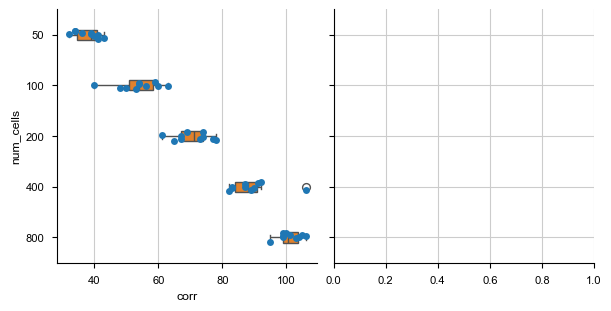

In [31]:
corr_df = reps_wide.apply(
    # lambda x: stats.pearsonr(x, full["fdr"])[0], axis=0 
    lambda x: np.sum(x), axis=0   
).to_frame("corr").reset_index()
fig, axes = plt.subplots(1, 2, figsize=(6, 3), sharey=True)
sns.stripplot(corr_df, x="corr", y="num_cells", linewidth=0, orient="h", ax=axes[0])
sns.boxplot(corr_df, x="corr", y="num_cells", width=0.2, orient="h", ax=axes[0])

In [55]:
corr_df.dtypes

num_cells      int64
replicate      int64
corr         float64
dtype: object

In [ ]:
pd.merge()

,c1,Chrom_Start,Chrom_End,stat_x,stat_y,stat_z,pval_x,pval_y,pval_z,stat,pval,fdr,fdr_peak,raw_peak,peak,num_cells,replicate
0,chr3,7675000,7700000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,NaN,NaN
1,chr3,7700000,7725000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,NaN,NaN
2,chr3,7750000,7775000,1.026215,1.010945,1.018041,0.675052,0.576728,0.623091,-0.418957,0.626287,1.000000,False,False,False,NaN,NaN
3,chr3,7775000,7800000,0.943952,1.070119,1.008112,0.091674,0.941895,0.574799,-1.148521,0.771969,1.000000,False,False,False,NaN,NaN
4,chr3,7800000,7825000,0.939155,1.040834,1.076496,0.076053,0.820795,0.954173,0.366777,0.388101,0.905568,False,False,False,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1255,chr3,9200000,9225000,1.099808,1.066886,1.059189,0.999948,0.995946,0.990226,-2654.690359,0.999880,1.000000,False,False,False,500.0,4.0
1256,chr3,9225000,9250000,1.012145,1.040918,0.970475,0.665499,0.922549,0.146705,-1.974355,0.850767,1.000000,False,False,False,500.0,4.0
1257,chr3,9250000,9275000,0.948975,0.987276,0.932683,0.057314,0.349235,0.018165,4.253730,0.073496,0.257237,False,False,False,500.0,4.0
1258,chr3,9275000,9300000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,500.0,4.0


## Brain cell types

In [32]:
reps = ["rep1", "rep2", "rep3"]
loader = sf.pp.FOF_CT_Loader({
    c: dtree["takei_science_2021", "25Kb", c] for c in reps
}, voxel_ratio={"X": 103, "Y": 103, "Z": 250}, obs_cols_add=["Cell_ID"])
celldfs = sf.pp.FOF_CT_Loader({
    c: dtree["takei_science_2021", "cell_type", c] for c in reps
}).read_data()

In [33]:
chr_id = "chr3"
adata = loader.create_adata(chr_id)
sf.pp.add_cell_type(adata, celldfs, "Cell_ID", "cluster label")
celltype_dict = {1:'Pvalb', 2:'Vip', 3:'Ndnf', 4:'Sst', 5:'Astro',
                 6:'Micro', 7:'Endo', 8:'Oligo', 9:'Ex'}
adata.obs["cell_type"] = adata.obs["cluster label"].map(celltype_dict)

In [34]:
adata[adata.obs["cell_type"]=="Ex"]

View of AnnData object with n_obs × n_vars = 2514 × 60
    obs: 'Cell_ID', 'cluster label', 'cell_type'
    var: 'Chrom_Start', 'Chrom_End'
    uns: 'Chrom'
    layers: 'X', 'Y', 'Z'

In [35]:
np.random.seed(100)
reps = []
for chr_id in loader.chr_ids[:-1]:
    caller = sf.tl.TADCaller(tree=False, method="pval")
    adata = loader.create_adata(chr_id)
    sf.pp.add_cell_type(adata, celldfs, "Cell_ID", "cluster label")
    adata = adata[adata.obs["cluster label"]==9].copy()
    res = caller.call_tads(adata)
    res["num_cells"] = adata.shape[0]
    res["replicate"] = -1
    reps.append(res)
    for n in [400, 800, 1600, 2400]:
        for r in range(3):
            sub_adata = adata[adata.obs.sample(n=n).index].copy()
            # Renormalize based on the subset
            del sub_adata.varp["var_X"]
            df = caller.call_tads(sub_adata)
            df["num_cells"] = n
            df["replicate"] = r
            reps.append(df)
reps = pd.concat(reps, ignore_index=True)
reps.to_csv(rep_path, index=False)

reps_wide = reps[reps.replicate >= 0].pivot_table(
    index=["c1", "Chrom_Start", "Chrom_End"],
    columns=["num_cells", "replicate"], values="fdr", sort=False
)
wide_idx = reps_wide.index.to_frame().reset_index(drop=True)
full = pd.merge(wide_idx, reps[reps.replicate < 0], on=wide_idx.columns.tolist())

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


<Axes: xlabel='corr', ylabel='num_cells'>

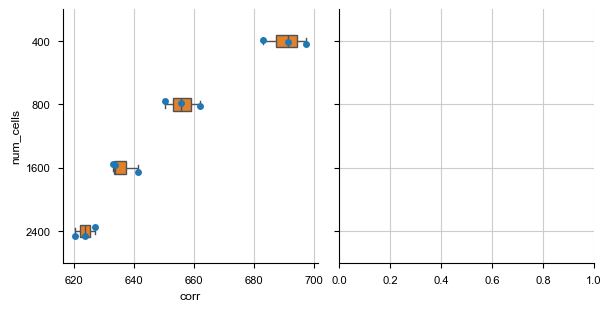

In [38]:
corr_df = reps_wide.apply(
    # lambda x: stats.pearsonr(x, full["fdr"])[0], axis=0 
    lambda x: np.sum(x), axis=0   
).to_frame("corr").reset_index()
fig, axes = plt.subplots(1, 2, figsize=(6, 3), sharey=True)
sns.stripplot(corr_df, x="corr", y="num_cells", linewidth=0, orient="h", ax=axes[0])
sns.boxplot(corr_df, x="corr", y="num_cells", width=0.2, orient="h", ax=axes[0])

## Differential TAD false positives

In [20]:
loader1 = sf.pp.FOF_CT_Loader({
    "rep1": dtree["takei_nature_2021", "25Kb", "rep1"]
}, voxel_ratio={"X": 103, "Y": 103, "Z": 250})
loader2 = sf.pp.FOF_CT_Loader({
    "rep2": dtree["takei_nature_2021", "25Kb", "rep2"]
}, voxel_ratio={"X": 103, "Y": 103, "Z": 250})


In [21]:
diff_res = []
for chr_id in loader1.chr_ids:
    adata1 = loader1.create_adata(chr_id)
    adata2 = loader2.create_adata(chr_id)
    diff = sf.tl.DiffRegion(adata1, adata2)
    diff_res.append(diff.diff_region(res_sf2))
diff_res = pd.concat(diff_res, ignore_index=True)

In [22]:
from statsmodels.stats import multitest as multi
diff_res["fdr"] = multi.multipletests(diff_res.pval, method="fdr_bh")[1]

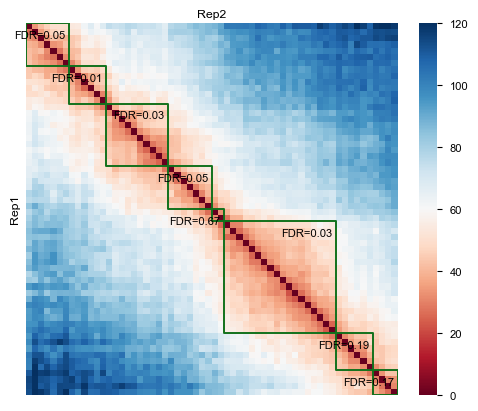

In [23]:
fig, ax = plt.subplots(figsize=(5, 4))
chr_id = "chr11"
adata1 = loader1.create_adata(chr_id)
adata2 = loader2.create_adata(chr_id)
sf.pl.pairwise_heatmap(
    X2=sf.pp.median_pdist(adata1, inplace=False),
    X1=sf.pp.median_pdist(adata2, inplace=False),
    y="Rep1", x="Rep2", ax=ax, vmax=120
)
diff = sf.tl.DiffRegion(adata1, adata2)
diff_res11 = diff.diff_region(res_sf2)
# sf.pl.pairwise_heatmap(diff.entry_pvals(adata1, adata2)[1])
sf.pl.add_domain_fdr(ax, diff_res11)

In [481]:
diff.entry_pvals(adata1, adata2).shape

(3, 60, 60)

In [482]:
diff_res["peak"] = diff_res.fdr < .05

In [460]:
diff_res.groupby("c1", sort=False).count()

,s1,e1,c2,s2,e2,stat1,stat2,level,idx1,idx2,stat,pval,fdr,log_fdr,size,peak
c1,,,,,,,,,,,,,,,,
chr1,6,6,6,6,6,5,5,6,6,6,6,6,6,6,6,6
chr2,6,6,6,6,6,5,5,6,6,6,6,6,6,6,6,6
chr3,7,7,7,7,7,6,6,7,7,7,7,7,7,7,7,7
chr4,8,8,8,8,8,7,7,8,8,8,8,8,8,8,8,8
chr5,5,5,5,5,5,4,4,5,5,5,5,5,5,5,5,5
chr6,5,5,5,5,5,4,4,5,5,5,5,5,5,5,5,5
chr7,8,8,8,8,8,7,7,8,8,8,8,8,8,8,8,8
chr8,4,4,4,4,4,3,3,4,4,4,4,4,4,4,4,4
chr9,9,9,9,9,9,8,8,9,9,9,9,9,9,9,9,9


In [459]:
diff_res.groupby("c1", sort=False)["peak"].sum()

c1
chr1     0
chr2     0
chr3     2
chr4     2
chr5     0
chr6     0
chr7     1
chr8     1
chr9     0
chr10    0
chr11    3
chr12    0
chr13    2
chr14    1
chr15    0
chr16    2
chr17    2
chr18    2
chr19    1
chrX     1
Name: peak, dtype: int64

<Axes: xlabel='size', ylabel='log_fdr'>

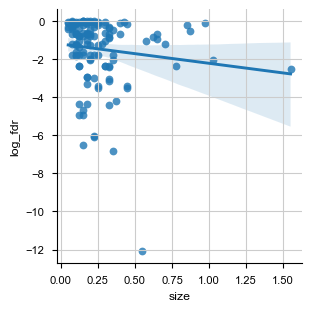

In [452]:
diff_res["size"] = (diff_res["s2"] - diff_res["s1"])/1e6
fig, ax = plt.subplots(figsize=(3, 3))
sns.regplot(diff_res, x="size", y="log_fdr", ax=ax)

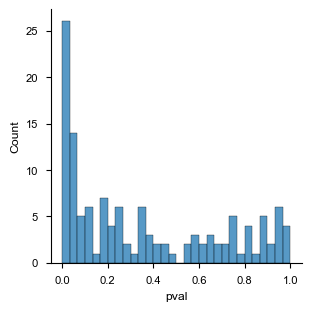

In [495]:
fig, ax = plt.subplots(figsize=(3, 3))
sns.histplot(diff_res.pval, bins=30, ax=ax)
ax.grid(False)

In [491]:
(diff_res.fdr < .01).mean()

0.0390625